# Natural Language Processing (NLP)

## Imports

In [99]:
import nltk
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\EGYPT_LAPTOP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\EGYPT_LAPTOP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\EGYPT_LAPTOP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Functions

In [3]:
# Preprocessing Method
def process_text(tweets):
    clean_tweets=[]
    le=WordNetLemmatizer()
    stop_words=stopwords.words('english')
    
    for tweet in tweets :
        #clean tweet
        tweet=re.sub("\W"," ",tweet)# remove punc
        tweet=re.sub('\s[a-zA-Z]\s',"",tweet) # remove character 
        tweet=re.sub('^\s+',"",tweet) # remove space 
        tweet=re.sub('\s+$',"",tweet) # remove space
        
        #remove stopwords ad lemmatization
        clean_tweet=[le.lemmatize(word.lower())  for word in tweet.split() if word.lower() not in stop_words]
        
        
        clean_tweets.append(clean_tweet)
    return clean_tweets

In [4]:
# Build Frequency Vector
def build_freq(text,y):
    freqs={}
    
    for i in range(len(text)):
        
        for word in text[i]:
            
            key=(word,y[i])
            
            if key in freqs:
                freqs[key]+=1
            else:
                freqs[key]=1
                
    return freqs

In [5]:
def build_freq_bayes(tweets,y):
    freqs={}
    
    for i in range(len(tweets)):
        
        for word in tweets[i]:
            
            key=word #key=(happy,1)
            
            if key not in freqs.keys():
                
                if y[i]==1:
                    freqs[key]=[1,0]
                else:
                    freqs[key]=[0,1]
            else:
                if y[i]==1:
                    freqs[key][0]+=1
                else:
                    freqs[key][1]+=1
                
    return freqs

In [6]:
# Build Vectors
def build_vectors(text,freq_dict):
    X=[]
    
    for word in text :
        x=np.zeros(3) #x=[0,0,0]
        x[0]=1    #x[1,0,0]
        for word in word:
            
            x[1]+=freq_dict.get((word,1),0) #x[1,sum(pos),0]
            x[2]+=freq_dict.get((word,0),0) #x[1,sum(pos),sum(neg)]
            
        X.append(x)
        
    return X

In [21]:
# Bayes Conditional Probability
def build_conditional_prop(freqs,n_pos,n_neg):
    V = len(freqs)
    prop_dict={}
    for word in freqs.keys():
        prop_dict[word]=[(freqs[word][0]+1)/(n_pos+V),(freqs[word][1]+1)/(n_neg+V)]
    return prop_dict

In [60]:
# Naive Bayes
def naive_bayes(tweet,prop_dict):
    result=0
    for word in tweet:
        result+=np.log10(prop_dict.get(word,0)[0]/prop_dict.get(word,0)[1])
    return result

In [102]:
# Word Embeddings Relation
def get_relation(entity1, relation1, entity2):
    vec = word_embeddings[relation1] - word_embeddings[entity1]  + word_embeddings[entity2]
    words = set([relation1, entity1, entity2])
    sim = -1
    res = None
    for word in word_embeddings.keys():
        s = np.dot(vec, word_embeddings[word]) / (np.linalg.norm(word_embeddings[word]) * np.linalg.norm(vec))
        
        if s > sim:
            if word not in words:
                sim = s
                res = word

    return res

# Sentiment Classification

## Dataset

In [71]:
# Read Dataset
df = pd.read_csv("Restaurant_Reviews.tsv", sep='\t')
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [72]:
# Preprocessing Text
y = df['Liked']
x_pre = process_text(df['Review'])
x_pre[0]

['wow', 'loved', 'place']

In [73]:
# Building frequency table
freq_table = build_freq(x_pre,y)
freq_table

{('wow', 1): 3,
 ('loved', 1): 10,
 ('place', 1): 56,
 ('crust', 0): 2,
 ('good', 0): 15,
 ('tasty', 0): 3,
 ('texture', 0): 2,
 ('nasty', 0): 3,
 ('stopped', 1): 2,
 ('late', 1): 1,
 ('may', 1): 3,
 ('bank', 1): 1,
 ('holiday', 1): 1,
 ('rick', 1): 1,
 ('steve', 1): 1,
 ('recommendation', 1): 2,
 ('selection', 1): 10,
 ('menu', 1): 13,
 ('great', 1): 61,
 ('price', 1): 13,
 ('nowam', 0): 1,
 ('getting', 0): 7,
 ('angry', 0): 1,
 ('andwant', 0): 1,
 ('damn', 0): 3,
 ('pho', 0): 3,
 ('honeslty', 0): 1,
 ('didntaste', 0): 1,
 ('fresh', 0): 2,
 ('potato', 0): 3,
 ('like', 0): 22,
 ('rubber', 0): 1,
 ('could', 0): 7,
 ('tell', 0): 2,
 ('made', 0): 6,
 ('ahead', 0): 1,
 ('time', 0): 25,
 ('kept', 0): 4,
 ('underwarmer', 0): 1,
 ('fry', 1): 6,
 ('touch', 1): 1,
 ('service', 1): 47,
 ('prompt', 1): 1,
 ('would', 0): 15,
 ('go', 0): 21,
 ('back', 0): 38,
 ('cashier', 0): 1,
 ('care', 0): 1,
 ('ever', 0): 17,
 ('whathad', 0): 1,
 ('say', 0): 8,
 ('still', 0): 5,
 ('ended', 0): 2,
 ('wayyy', 0):

In [74]:
# Get features
x = build_vectors(x_pre,freq_table)
x[0:5]

[array([ 1., 69., 48.]),
 array([ 1., 66., 17.]),
 array([1., 8., 8.]),
 array([ 1., 22.,  3.]),
 array([ 1., 97.,  8.])]

In [75]:
# Split into train and test sets
x_train,x_test,y_train,y_test = train_test_split(x,np.array(y),test_size=0.2,shuffle=True, random_state= 42)

## SKlearn

In [77]:
# Logistic Regression
model=LogisticRegression()
model.fit(x_train,y_train)

LogisticRegression()

In [16]:
# Evaluating Model
from sklearn.metrics import accuracy_score
y_pred=model.predict(x_test)
print("Accuracy : ",accuracy_score(y_test,y_pred))

Accuracy :  0.845


In [17]:
# Testing Model
test_in = [ 'The food was awesome','Worst Experience Ever']
test_out = model.predict(build_vectors(process_text(test_in),freq_table))
print(test_out)

[1 0]


## Naive Bayes

In [68]:
# Reshape X and Y
x_bayes=np.array(x).reshape(np.array(x).shape[0],1,np.array(x).shape[1])
y_bayes=np.array(y).reshape(-1,1)

In [64]:
# Frequency Table
freq_table_bayes = build_freq_bayes(x_pre,y)

In [65]:
# Number of positive and negative tweets
N_pos=0
N_neg=0
for i in freq_table_bayes.keys():
    N_pos+=freq_table_bayes[i][0]
    N_neg+=freq_table_bayes[i][1]

In [66]:
# Model
prop_dict=build_conditional_prop(freq_table_bayes,N_pos,N_neg)

In [67]:
# Testing Model
test_bayes1 = naive_bayes(process_text(test_in)[0],prop_dict)
test_bayes2 = naive_bayes(process_text(test_in)[1],prop_dict)

print(test_bayes1,test_bayes2)

1.1022604162430791 -1.0287682235712112


## Lazy Classifier

In [78]:
# Lazy Classifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
x_train,x_test,y_train,y_test = np.array(x_train, dtype=np.float32), \
    np.array(x_test, dtype=np.float32),np.array(y_train, dtype=np.float32), np.array(y_test, dtype=np.float32)
models, predictions = clf.fit(x_train, x_test, y_train, y_test)
models

100%|██████████| 29/29 [00:02<00:00, 10.44it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SGDClassifier,0.85,0.85,0.85,0.85,0.02
CalibratedClassifierCV,0.83,0.84,0.84,0.83,0.23
LGBMClassifier,0.83,0.83,0.83,0.84,0.16
AdaBoostClassifier,0.83,0.83,0.83,0.83,0.45
KNeighborsClassifier,0.83,0.83,0.83,0.83,0.04
XGBClassifier,0.83,0.83,0.83,0.83,0.35
LogisticRegression,0.82,0.83,0.83,0.82,0.03
SVC,0.82,0.83,0.83,0.82,0.05
LinearSVC,0.82,0.82,0.82,0.82,0.04


In [82]:
# Trying XGB Classifier
XGB_model = XGBClassifier()
XGB_model.fit(x_train,y_train)
y_pred = XGB_model.predict(x_test)

class_report = metrics.classification_report(y_test,y_pred)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82        96
         1.0       0.83      0.85      0.84       104

    accuracy                           0.83       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.83      0.83      0.83       200



[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

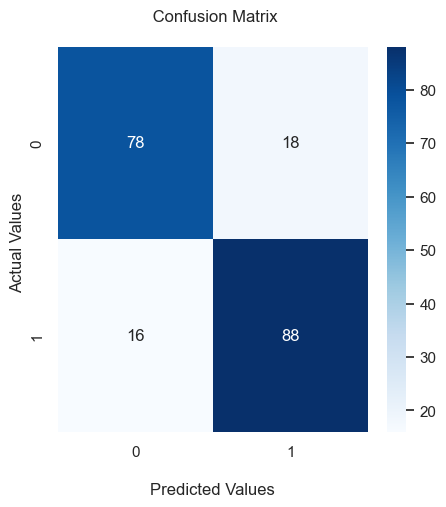

In [89]:
# Displaying Confusion Matrix
cf_matrix = confusion_matrix(y_test,y_pred)
sns.set(rc={'figure.figsize':(5,5)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title(' Confusion Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

In [90]:
#Model Evaluation
accuracy  = metrics.accuracy_score(y_test,y_pred)
recall = metrics.recall_score(y_test,y_pred)
precision = metrics.precision_score(y_test,y_pred)
f1_score = metrics.f1_score(y_test,y_pred)

print(f'Model Accuracy = {100*accuracy:0.3} %' )
print(f'Model recall = {100*recall:0.3} %' )
print(f'Model precision = {100*precision:0.3} %' )
print(f'Model f1_score = {100*f1_score:0.3} %' )

Model Accuracy = 83.0 %
Model recall = 84.6 %
Model precision = 83.0 %
Model f1_score = 83.8 %


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

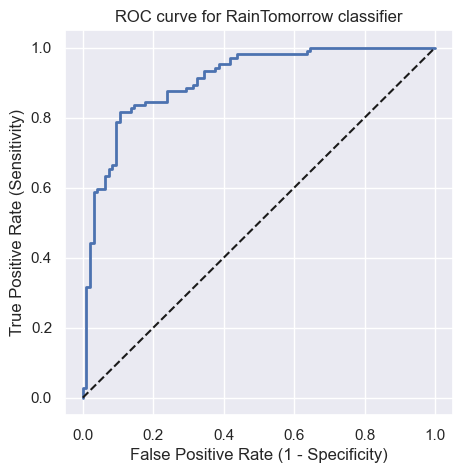

In [91]:
#ROC Curve
y_pred_proba = XGB_model.predict_proba(x_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.title('ROC curve for RainTomorrow classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [92]:
# ROC Evaluation
ROC_AUC = metrics.roc_auc_score(y_test,y_pred_proba)
print(f'Model ROC_AUC = {100*ROC_AUC:0.3} %' )

Model ROC_AUC = 90.8 %


In [98]:
# Testing Model
test_out = XGB_model.predict(build_vectors(process_text(test_in),freq_table))
print(test_out)

[1 0]


# Word Embeddings

In [104]:
word_embeddings = pickle.load(open('word_embedding_test.p', 'rb'))
len(word_embeddings)

40

In [106]:
word_embeddings.keys()

dict_keys(['country', 'city', 'man', 'big', 'small', 'oil', 'woman', 'town', 'gas', 'happy', 'quick', 'smaller', 'fear', 'bigger', 'village', 'cold', 'doctor', 'worry', 'stress', 'sad', 'calm', 'anger', 'engineer', 'midfielder', 'king', 'nurse', 'scientist', 'continent', 'petroleum', 'quicker', 'queen', 'composer', 'painter', 'colder', 'Messi', 'Mozart', 'Einstein', 'Picasso', 'joyful', 'housekeeper'])

In [105]:
get_relation('Messi','midfielder','Picasso')

'painter'

In [107]:
get_relation('man','king','woman')

'queen'